In [1]:
%reload_ext autoreload

# Imports

import os
import sys
module_path = os.path.abspath(os.path.join('../image_gen_dm')) # or the path to your source code
sys.path.append(str(module_path))

import tensorflow as tf
import tf_keras as tfk
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

tfkl = tfk.layers
tfpl = tfp.layers
tfd = tfp.distributions

TF_ENABLE_ONEDNN_OPTS=0
os.environ['TF_ENABLE_ONEDNN_OPTS'] = str(TF_ENABLE_ONEDNN_OPTS)
os.environ['TG_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import denoising_vae as dvae
import denoising_vae.constants as consts

print('Tensorflow Version:', tf.__version__)
print("Available GPUs: ", len(tf.config.list_physical_devices('GPU')))

2024-04-30 17:08:24.017908: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 17:08:29.130728: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-30 17:08:29.147722: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-30 17:08:29.147776: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUM

Tensorflow Version: 2.16.1
Available GPUs:  1


In [2]:
# Constants

IMAGE_SIZE = 64
FLATTENED_SIZE = IMAGE_SIZE * IMAGE_SIZE * 3

ENCODER_HIDDEN_SIZES = [
    [256, 32],
    [1024, 64],
    [4096, 256],
    [8192, 512],
    [256, 64, 32],
    [1024, 256, 64],
    [4096, 1024, 256],
    [8192, 2048, 512],
    [256, 128, 64, 32],
    [1024, 512, 256, 64],
    [4096, 2048, 1024, 256],
    [8192, 2048, 1024, 512],
    [4096, 2048, 1024, 256, 128],
    [8192, 2048, 1024, 512, 256],
]

DECODER_HIDDEN_SIZES = [] # Construct from encoder hidden sizes in reverse

for hidden_sizes in ENCODER_HIDDEN_SIZES:
    DECODER_HIDDEN_SIZES.append(hidden_sizes[::-1])

MODEL_NAMES = []

for i in range(len(ENCODER_HIDDEN_SIZES)):
    if i < 9:
        MODEL_NAMES.append(f'ncvae0{i+1}')
    else:
        MODEL_NAMES.append(f'ncvae{i+1}')

LATENT_DIM = 2

LEARNING_RATE = 1e-4

VAL_PERCENTAGE = 0.1

# Models to run

MODEL_START = 8 # Rasmus 0-8, Viktor 9-13
MODEL_COUNT = 1

In [3]:
# Dataset loading

train_ds, val_ds = dvae.utils.load_datasets(val_percentage=VAL_PERCENTAGE)

Loading datasets...
Training Images:  8100
Evaluation Images:  900
Training Images (post-duplication):  8100
Validation Images (post-duplication):  900


In [4]:
# Model class

# This code is heavily based on the Keras Team's example on Convolutional VAEs with only minor modifications.
# The original code can be found at: https://github.com/keras-team/keras-io/blob/master/examples/generative/vae.py

# Author: [fchollet](https://twitter.com/fchollet)
# Licensed under the Apache License 2.0. See LICENSE file in the root directory for more information.


class Sampling(tfkl.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class NCVAE(tfk.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tfk.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            input_data, target_data = data

            noise_levels = tf.random.uniform(shape=(consts.BATCH_SIZE,), minval=0, maxval=consts.NOISE_LEVELS - 1, dtype=tf.int32)

            def apply_noise_to_image(image, noise_level):
                return dvae.utils.apply_noise(image, noise_level)
            
            input_data_noisy = tf.map_fn(
                lambda x: apply_noise_to_image(x[0], x[1]), 
                (input_data, noise_levels), dtype=tf.float32)

            z_mean, z_log_var, z = self.encoder(input_data_noisy)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.losses.binary_crossentropy(target_data, reconstruction), 
                    axis=(1,2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, input_data, training=False):
        _, _, z = self.encoder(input_data)
        reconstructed_image = self.decoder(z)

        return reconstructed_image


In [5]:
# Encoder

models = []

for i in range(MODEL_START, MODEL_START + MODEL_COUNT):
    print(f'Model {i+1}')

    image_input = tfkl.Input(shape=consts.INPUT_SHAPE, name='image_input')

    flattened_image = tfkl.Flatten()(image_input)

    x = flattened_image
    for layer_size in ENCODER_HIDDEN_SIZES[i]:
        x = tfkl.Dense(layer_size, 
                    activation='relu',
                    kernel_initializer='glorot_uniform')(x)
        
    z_mean = tfkl.Dense(LATENT_DIM, name='z_mean', kernel_initializer='glorot_uniform')(x)
    z_log_var = tfkl.Dense(LATENT_DIM, name='z_log_var', kernel_initializer='glorot_uniform')(x)

    z = Sampling()([z_mean, z_log_var])

    encoder = tfk.Model(inputs=image_input, outputs=[z_mean, z_log_var, z], name='encoder')
    encoder.summary()

    # Decoder

    latent_inputs = tfkl.Input(shape=(LATENT_DIM,))

    y = latent_inputs
    for layer_size in DECODER_HIDDEN_SIZES[i]:
        y = tfkl.Dense(layer_size, 
                    activation='relu',
                    kernel_initializer='glorot_uniform')(y)
        
    reconstructed_flattened_image = tfkl.Dense(FLATTENED_SIZE, kernel_initializer='glorot_uniform', activation='sigmoid')(y)
    reshaped_image = tfkl.Reshape(consts.OUTPUT_SHAPE)(reconstructed_flattened_image)

    decoder = tfk.Model(inputs=latent_inputs, outputs=reshaped_image, name='decoder')
    decoder.summary()

    # Model
        
    model = NCVAE(encoder, decoder)
    model.compile(optimizer=tfk.optimizers.Adam(learning_rate=LEARNING_RATE))

    models.append(model)

Model 9
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 flatten (Flatten)           (None, 12288)                0         ['image_input[0][0]']         
                                                                                                  
 dense (Dense)               (None, 256)                  3145984   ['flatten[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  32896     ['dense[0][0]']               
                                                                                    

Epoch 1/128
Instructions for updating:
Use fn_output_signature instead


I0000 00:00:1714496928.546573      76 service.cc:145] XLA service 0x7f8a844f5d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714496928.546735      76 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-04-30 17:08:48.567954: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-30 17:08:48.607196: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1714496928.710152      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


64/64 [==============================] - 31s 229ms/step - loss: 2816.0148 - reconstruction_loss: 2765.4285 - kl_loss: 13.1846 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/128
64/64 [==============================] - 11s 166ms/step - loss: 2697.9519 - reconstruction_loss: 2686.4739 - kl_loss: 7.5887 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/128
64/64 [==============================] - 11s 171ms/step - loss: 2688.8099 - reconstruction_loss: 2684.0266 - kl_loss: 4.2973 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/128
64/64 [==============================] - 10s 162ms/step - loss: 2687.3873 - reconstruction_loss: 2681.9912 - kl_loss: 3.6447 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/128
64/64 [==============================] - 10s 163ms/step - loss: 2676.7923 - rec

2024-04-30 17:31:30.777471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


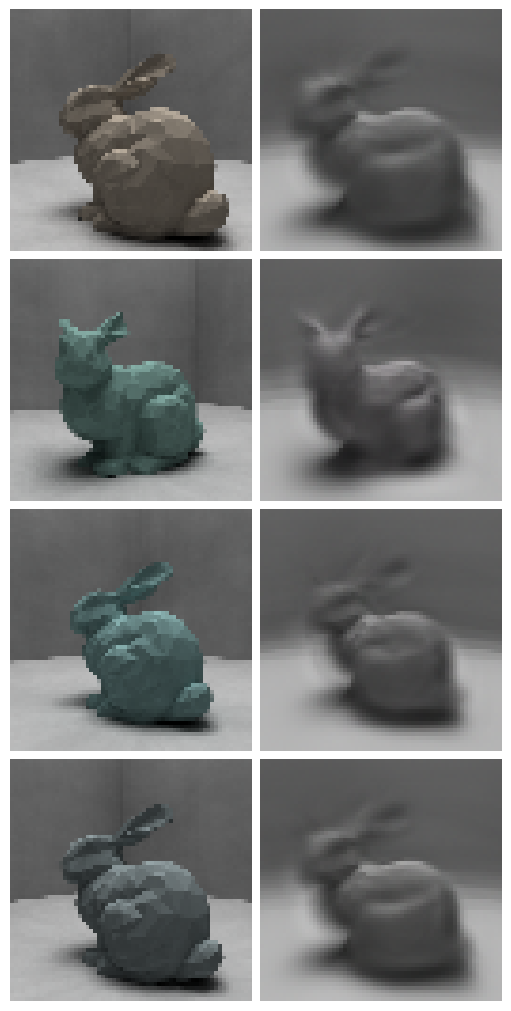

In [6]:
# Run model

epochs = 128

i = MODEL_START
for model in models:

    history = dvae.run_model(model=model, train_ds=train_ds, val_ds=val_ds, epochs=epochs, name=MODEL_NAMES[i], plot=False)

    pd.DataFrame(history.history).to_csv(f'res/histories/{MODEL_NAMES[i]}.csv')

    dvae.val_model(model)

    i += 1
